In [142]:
import glob
import numpy as np
import preprocessing as pp
import matplotlib.pyplot as plt
from keras import backend as K
from IPython.display import Image as IM
from keras import layers, models, optimizers
from keras.utils.np_utils import to_categorical
from IPython.display import display_jpeg,display_png
from keras.applications import VGG16, Xception,ResNet50
from keras.preprocessing.image import ImageDataGenerator

In [73]:
def original_model(in_shpae):
    model = models.Sequential()
    model.add(layers.Conv2D(
        4, (3, 3), activation = 'relu',padding = 'same',input_shape = in_shpae))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(16, (3, 3), activation= 'relu', padding= 'same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding = 'same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding = 'same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding = 'same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(7, activation = 'softmax'))
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [74]:
def xception_model(in_shpae):
    return model

In [107]:
def vgg16_model():
    base_vgg = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = X_train[0].shape)
    
    model = models.Sequential()
    model.add(base_vgg)
    model.add(layers.Conv2D(512, (3,3), activation='relu', padding = 'same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(7, activation = 'softmax'))
    for layer in base_vgg.layers[:-4]:
        layer.trainable = False
    model.compile(optimizer=optimizers.RMSprop(lr = 1e-5),
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [ ]:
# def train_generator():
#     train_datagen = ImageDataGenerator(rescale = 1./255)
#     return train_generator

In [108]:
# 前処理
X_train = []
y_train = []
datas = glob.glob('./data/*')
imsize = (224,224)
for data in datas:
    class_label = pp.data_to_label(data)
    img = pp.load_image(data,imsize)
    X = np.array(img)
    X_train.append(X)
    y_train.append(class_label)
X_train,y_train = pp.list_to_array(X_train, y_train)
y_train = to_categorical(y_train)

In [121]:
# build_modelフェーズ
original_model = original_model(X_train[0].shape)
original_model.fit(X_train, y_train, epochs = 12)

In [47]:
# xception_model = xception_model(in_shape)

In [109]:
vgg16_model = vgg16_model()
vgg16_model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
100/100 [==============================] - 44s 443ms/step - loss: 1.9418 - accuracy: 0.2200
Epoch 2/10
100/100 [==============================] - 43s 429ms/step - loss: 1.4034 - accuracy: 0.4600
Epoch 3/10
100/100 [==============================] - 39s 391ms/step - loss: 1.2204 - accuracy: 0.6000
Epoch 4/10
100/100 [==============================] - 47s 471ms/step - loss: 1.0873 - accuracy: 0.6200
Epoch 5/10
100/100 [==============================] - 45s 450ms/step - loss: 1.0147 - accuracy: 0.7400
Epoch 6/10
100/100 [==============================] - 33s 334ms/step - loss: 0.9287 - accuracy: 0.7700
Epoch 7/10
100/100 [==============================] - 34s 344ms/step - loss: 0.8585 - accuracy: 0.7700
Epoch 8/10
100/100 [==============================] - 32s 322ms/step - loss: 0.7849 - accuracy: 0.8100
Epoch 9/10
100/100 [==============================] - 37s 369ms/step - loss: 0.7325 - accuracy: 0.8200
Epoch 10/10
100/100 [==============================] - 32s 322ms/step - l

In [145]:
vgg16_model.save_weights('vgg16_model.hdf5')

In [136]:
# 予測
X_test = []
test_data = './data/12_0052.png'
imsize = (224,224)
test_img = pp.load_image(test_data,imsize)
x_test = np.array(test_img)
X_test.append(x_test)
X_test = np.array(X_test)
# y_pred = original_model.predict(X_test)
y_pred = vgg16_model.predict(X_test)


予想年齢:[[0.47531176 0.20354293 0.14954913 0.10099061 0.05130594 0.00897158
  0.01032809]]


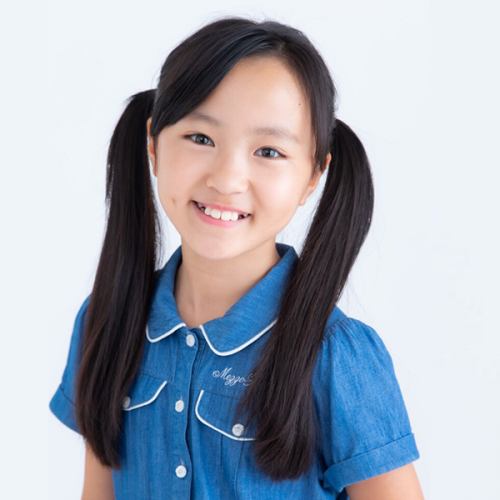

In [137]:
print('予想年齢:{}'.format(y_pred))
if test_data[-3:] =='png':
    display_png(IM(test_data))
elif test_data[-3:] =='jpg':
    display_jpeg(IM(test_data))

In [138]:
vgg16_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 32263     
Total params: 17,106,759
Trainable params: 9,471,495
Non-trainable params: 7,635,264
_________________________________________________________________


In [139]:
# ヒートマップ
np.argmax(y_pred[0])
img_output = vgg16_model.output[:,1]
last_conv_layer = vgg16_model.get_layer('conv2d_31')
grads = K.gradients(img_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([vgg16_model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_test])
for i in range(512):
    conv_layer_output_value[: , : , i] *= pooled_grads_value[i]
hetamap = np.mean(conv_layer_output_value, axis=-1)

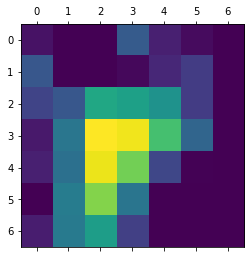

In [140]:
heatmap = np.maximum(hetamap, 0)
heatmap/= np.max(heatmap)
plt.matshow(heatmap)

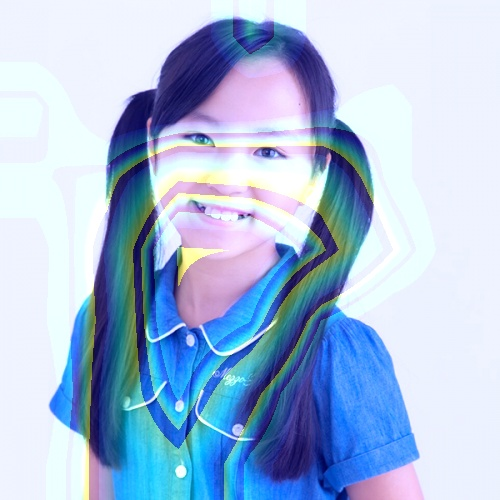

In [144]:
import cv2
img3 = cv2.imread(test_data)
heatmap = cv2.resize(heatmap, (img3.shape[1], img3.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
saveimg = heatmap * 0.4 + img3
savename = './heat.jpg'
cv2.imwrite(savename, saveimg)
display_jpeg(IM(savename))

(array([ 4., 31., 29., 22., 11.,  2.,  1.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

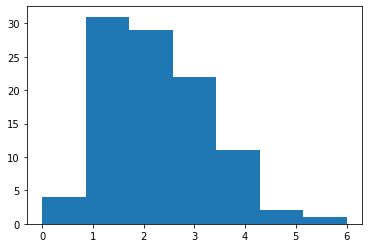

In [6]:
#　labelの可視化
plt.hist(x = y_train,bins=7)